In [36]:
import readfof
from pyspark.sql import SparkSession
import numpy as np
import scipy.spatial as SS
from scipy.spatial import KDTree
from visualize_graph import *

In [37]:
spark = SparkSession.builder \
        .master("spark://master:7077")\
        .appName("CosmoSparkApplication")\
        .getOrCreate()

In [38]:
sc = spark.sparkContext

In [39]:
def read_cosmo_data(file_path):

    # Read Fof
    FoF = readfof.FoF_catalog(
        file_path,           # simulation directory
        2,                   # snapnum, indicating the redshift (z=1)
        long_ids = False,
        swap = False,
        SFR = False,
        read_IDs = False
        )

    pos = FoF.GroupPos/1e06             # Halo positions in Gpc/h 
    mass_raw = FoF.GroupMass * 1e10     # Halo masses in Msun/h

    dim = pos.shape[0]
    id = np.arange(dim, dtype=int).reshape(dim, 1)
    pos_mass_matrix = np.hstack([id, pos, mass_raw.reshape(dim, 1)])

    return pos_mass_matrix

def find_cut(pos_mass_array, percent):

    return np.quantile(pos_mass_array[:, 4], percent)

def mass_filter(pos_mass_cut_rdd):

    mass = pos_mass_cut_rdd[0][:, 4]
    cut = pos_mass_cut_rdd[1]
    
    #if mass >= cut:
        #return pos_mass_cut_rdd[0]
    return pos_mass_cut_rdd[0][mass >= cut, :]

def assign_box(point, boxes):
    id, x, y, z, m = point
    box_assign = []
    
    for box_name, ((x_min, x_max), (y_min, y_max), (z_min, z_max)) in boxes.items():
     if (x_min <= x <= x_max) and (y_min <= y <= y_max) and (z_min <= z <= z_max):
           box_assign.append((box_name, point))
    
    return box_assign

# KD-tree to find edges in boxes
def get_edges(pos_mass_points):
    pos_mass_matrix = np.array(pos_mass_points)
    pos = pos_mass_matrix[:,1:4]
    id = pos_mass_matrix[:,0]

    kd_tree = SS.KDTree(pos, leafsize=16, boxsize=1.00001)
    edge_idx = kd_tree.query_pairs(r=0.2, output_type="ndarray")
    edge_idx = np.array([sorted((id[i], id[j])) for i, j in edge_idx])
    
    return edge_idx


# find unique pairs of edges between 2 boxes (pere uniche)
def unique_pears(mat1, mat2):
    mat = np.vstack((mat1, mat2))
    
    return np.unique(mat, axis=0)


In [40]:
# simulations parameters

sim_pars_file = np.loadtxt("/mnt/cosmo_GNN/latin_hypercube_params.txt", dtype=float)
sim_pars_list = [(i, j) for i, j in enumerate(sim_pars_file)]
sim_pars_file_rdd = sc.parallelize(sim_pars_list)

In [41]:
N_sims = 100

# path list (key, value)
path_list = [(i, "/mnt/cosmo_GNN/Data/"+str(i)) for i in range(N_sims)]

cosmo_rdd = sc.parallelize(path_list)\
            .mapValues(read_cosmo_data)


In [136]:
cosmo_rdd.take(2)

[(96,
  array([0.00000000e+00, 3.44623357e-01, 8.56006265e-01, 1.41554251e-01,
         1.52590538e+15])),
 (96,
  array([1.00000000e+00, 8.19944084e-01, 6.34456575e-02, 6.64648294e-01,
         1.48354653e+15]))]

In [42]:
cut_rdd = cosmo_rdd.mapValues(lambda x: find_cut(x,0.997))

In [43]:
joined_rdd = cosmo_rdd.join(cut_rdd)

In [44]:
pos_mass_filtered = joined_rdd.mapValues(mass_filter)\
                                .filter(lambda x: x is not None)

In [45]:
#pos_mass_filtered.take(2)

In [46]:
cosmo_rdd = pos_mass_filtered.flatMapValues(lambda x: x)

In [47]:
min_x, min_y, min_z = 0, 0, 0 #min_coords
max_x, max_y, max_z = 1, 1, 1 #max_coords

r = 0.1  

# Compute the midpoint for every dimension
x_mid = np.mean([min_x, max_x])
y_mid = np.mean([min_y, max_y])
z_mid = np.mean([min_z, max_z])

boxes = {
    "box1": [(min_x    , x_mid + r ), (min_y    , y_mid + r), (min_z    , z_mid + r )],
    "box2": [(x_mid - r, max_x     ), (min_y    , y_mid + r), (min_z    , z_mid + r )],
    "box3": [(min_x    , x_mid + r ), (y_mid - r, max_y    ), (min_z    , z_mid + r )],
    "box4": [(x_mid - r, max_x     ), (y_mid - r, max_y    ), (min_z    , z_mid + r )],
    "box5": [(min_x    , x_mid + r ), (min_y    , y_mid + r), (z_mid - r, max_z    )],
    "box6": [(x_mid - r, max_x     ), (min_y    , y_mid + r), (z_mid - r, max_z    )],
    "box7": [(min_x    , x_mid + r ), (y_mid - r, max_y    ), (z_mid - r, max_z    )],
    "box8": [(x_mid - r, max_x     ), (y_mid - r, max_y    ), (z_mid - r, max_z    )],
}


In [48]:
point_box_rdd = cosmo_rdd.flatMapValues(lambda p: assign_box(p, boxes))

In [134]:
point_box_rdd.take(2)

[(32,
  ('box3',
   array([0.00000000e+00, 1.67560816e-01, 6.14759684e-01, 8.97844359e-02,
          1.95483853e+15]))),
 (32,
  ('box5',
   array([1.00000000e+00, 4.10624981e-01, 1.28075734e-01, 6.64362788e-01,
          1.86257015e+15])))]

In [49]:
boxes_rdd_sim = point_box_rdd.groupByKey()\
                            .mapValues(lambda x: list(x))
                        #.map(lambda x: (str(x[0]) + list(x[1])[0][0], list(x[1])[0][1]))\
                        #.groupByKey()\
                        

In [50]:
boxes_rdd = point_box_rdd.map(lambda x: (str(x[0]) + '_' + list(x[1])[0], list(x[1])[1]))\
                        .groupByKey()\
                        .mapValues(list)

In [51]:
edges_rdd = boxes_rdd.mapValues(get_edges)

In [52]:
rdd_key_sim = edges_rdd.map(lambda x: (int(x[0][0]), x[1]))\
                     #.reduce(lambda a, b: unique_pears(a[1], b[1]))

In [53]:
final = rdd_key_sim.reduceByKey(lambda a, b: unique_pears(a, b))

In [54]:
final.take(2)

[(0,
  array([[  0.,   6.],
         [  0.,  83.],
         [  0., 116.],
         ...,
         [169., 183.],
         [171., 172.],
         [184., 185.]])),
 (1,
  array([[   0.,    5.],
         [   0.,    7.],
         [   0.,    8.],
         ...,
         [1014., 1029.],
         [1018., 1020.],
         [1022., 1026.]]))]

In [127]:
sim = 1
num = pos_mass_filtered.filter(lambda x: x[0] == sim).keys().take(1)[0]
edge_list = final.filter(lambda x: x[0] == sim).values().take(1)[0]
pos_mas_plot = pos_mass_filtered.filter(lambda x: x[0] == num).values().take(1)[0][:,1:5]
pars = sim_pars_file_rdd.filter(lambda x: x[0] == num).values().take(1)[0]

In [128]:
pos_mas_plot.shape

(641, 4)

In [129]:
np.max(edge_list)

np.float64(1029.0)

IndexError: index 642 is out of bounds for axis 0 with size 641

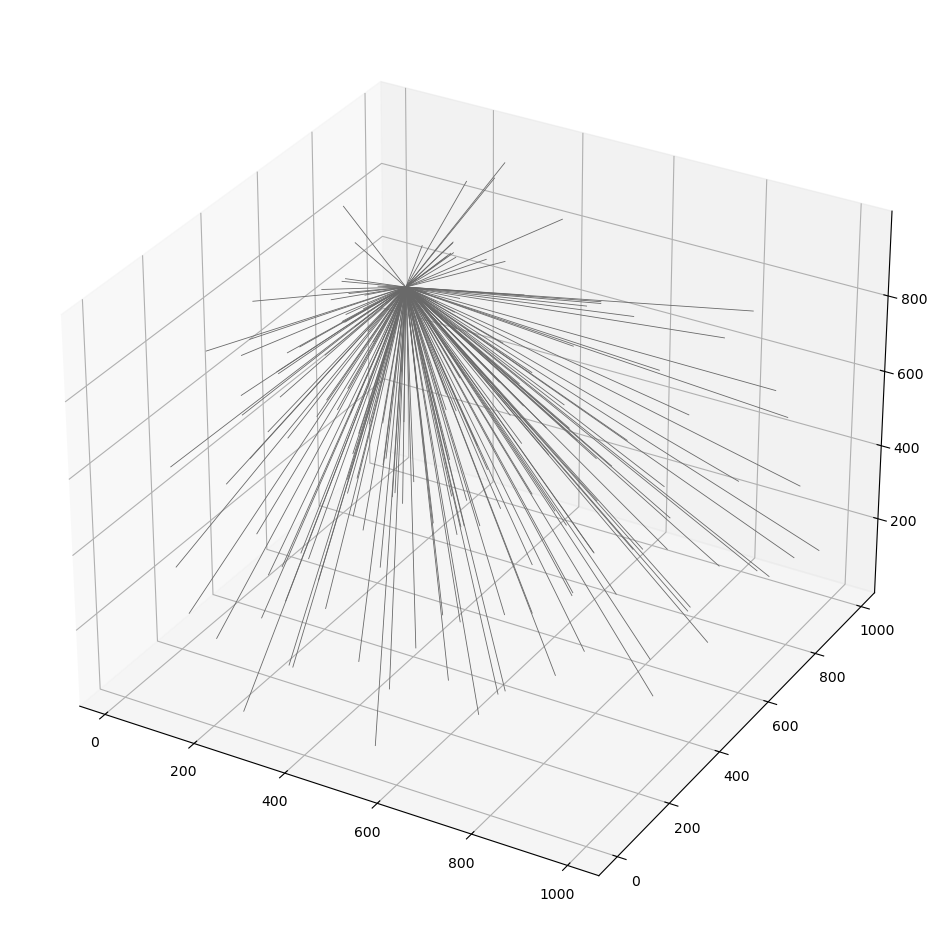

In [130]:
visualize_graph(num, pos_mas_plot, pars, edge_list)

In [76]:
final.filter(lambda x: x[0] == sim).values().take(1)[0]

array([[   0.,    5.],
       [   0.,    7.],
       [   0.,    8.],
       ...,
       [1014., 1029.],
       [1018., 1020.],
       [1022., 1026.]])

In [22]:
edge_list.T.tolist()

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  4.0,
  4.0,
  4.0,
  4.0,
  4.0,
  4.0,
  4.0,
  4.0,
  4.0,
  4.0,
  4.0,
  4.0,
  4.0,
  4.0,
  4.0,
  4.0,
  4.0,
  5.0,
  5.0,
  5.0,
  6.0,
  6.0,
  6.0,
  6.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  8.0,
  8.0,
  8.0,
  9.0,
  9.0,
  9.0,
  9.0,
  9.0,
  9.0,
  9.0,
  9.0,
  9.0,
  10.0,
  10.0,
  11.0,
  11.0,
  11.0,
  11.0,
  12.0,
  12.0,
  13.0,
  13.0,
  14.0,
  14.0,
  14.0,
  14.0,
  15.0,
  15.0,
  16.0,
  16.0,
  16.0,
  16.0,
  17.0,
  17.0,
  17.0,
  17.0,
  17.0,
  17.0,
  17.0,
  17.0,
  17.0,
  18.0,
  18.0,
  18.0,
  18.0,
  18.0,
  18.0,
  18.0,
  19.0,
  19.0,
  19.0,
  19.0,
  19.0,
  19.0,
  19.0,
  19.0,
  19.0,
  20.0,
  20.0,
  20.0,
  20.0,
  20.0,
  20.0,
  20.0,
  20.0,
  20.0,
  20.0,
  20.0,
  21.0,
  21.0,
  21.0,
  21.0,
  22.0,
  22.0,
  22.0,
  22.0,
  22.0,
  22.0,
  22.0,
  

In [23]:
sc.stop()
spark.stop()